# auto encoder

### 介绍

通过对数据的七个百分比进行编码，然后再解码，看看解码后的数据和原始数据的差异。

### 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 定义网络

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(7, 6),
            nn.ReLU(True),
            nn.Linear(6, 5),
            nn.ReLU(True),
            nn.Linear(5, 4),
            nn.ReLU(True),
            nn.Linear(4, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(True),
            nn.Linear(4, 5),
            nn.ReLU(True),
            nn.Linear(5, 6),
            nn.ReLU(True),
            nn.Linear(6, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 加载数据集

In [4]:
df = pd.read_excel("Problem_C_Data_Wordle_new.xlsx")
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),normal_value
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,0.343806
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,0.491583
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,0.097901
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,0.187709
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,0.308737


In [5]:
df_Distribution = df.iloc[:, 5:12]
print('df_Distribution.shape = \n', df_Distribution.shape)
print('df_Distribution.head() = \n', df_Distribution.head())

df_Distribution.shape = 
 (359, 7)
df_Distribution.head() = 
    1 try  2 tries  3 tries  4 tries  5 tries  6 tries  7 or more tries (X)
0      0        2       17       37       29       12                    2
1      0        4       21       38       26        9                    1
2      0        2       16       38       30       12                    2
3      0        3       21       40       25        9                    1
4      0        2       17       35       29       14                    3


In [6]:
Distribution = df_Distribution.to_numpy()
print('Distribution.shape = \n', Distribution.shape)
print('Distribution = \n', Distribution)

Distribution.shape = 
 (359, 7)
Distribution = 
 [[ 0  2 17 ... 29 12  2]
 [ 0  4 21 ... 26  9  1]
 [ 0  2 16 ... 30 12  2]
 ...
 [ 1  3 13 ... 30 22  4]
 [ 1  5 23 ... 24 14  2]
 [ 1  3 23 ... 24  9  1]]


In [7]:
Distribution = Distribution / 100

In [8]:
Distribution.astype(np.float32)

array([[0.  , 0.02, 0.17, ..., 0.29, 0.12, 0.02],
       [0.  , 0.04, 0.21, ..., 0.26, 0.09, 0.01],
       [0.  , 0.02, 0.16, ..., 0.3 , 0.12, 0.02],
       ...,
       [0.01, 0.03, 0.13, ..., 0.3 , 0.22, 0.04],
       [0.01, 0.05, 0.23, ..., 0.24, 0.14, 0.02],
       [0.01, 0.03, 0.23, ..., 0.24, 0.09, 0.01]], dtype=float32)

In [9]:
Distribution_tensor = torch.from_numpy(Distribution).float().to(device)

### 构造数据集

In [10]:
train_size = int(0.7 * len(Distribution))

In [11]:
# 打乱数据
indices = np.arange(len(Distribution))
np.random.shuffle(indices)
Distribution_shuffled = Distribution[indices]

In [12]:
test_indices = indices[train_size:]

In [13]:
# 训练集
train_data = Distribution_shuffled[:train_size]
print('train_data.shape = \n', train_data.shape)

# 测试集
test_data = Distribution_shuffled[train_size:]
print('test_data.shape = \n', test_data.shape)

train_data.shape = 
 (251, 7)
test_data.shape = 
 (108, 7)


In [14]:
# 转换为tensor
train_data = torch.from_numpy(train_data).float().to(device)
test_data = torch.from_numpy(test_data).float().to(device)

In [15]:
train_data[:5]

tensor([[0.0200, 0.1100, 0.3400, 0.3200, 0.1500, 0.0600, 0.0100],
        [0.0100, 0.0700, 0.1900, 0.2700, 0.2400, 0.1700, 0.0500],
        [0.0100, 0.0200, 0.1300, 0.2900, 0.3100, 0.2000, 0.0300],
        [0.0100, 0.0400, 0.1600, 0.3000, 0.3000, 0.1700, 0.0200],
        [0.0000, 0.0600, 0.3000, 0.3300, 0.1900, 0.0900, 0.0200]])

In [16]:
# batch大小
batch_size = 64

# 数据加载器
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print('len(train_loader) = ', len(train_loader))
print('len(test_loader) = ', len(test_loader))

len(train_loader) =  4
len(test_loader) =  2


### 模型声明

Creates a criterion that measures the mean squared error (squared L2 norm) between
each element in the input :math:`x` and target :math:`y`.

The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

$$
    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2,
$$

where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then:

$$
\ell(x, y) =
\begin{cases}
    \operatorname{mean}(L), &  \text{if reduction} = \text{`mean';}\\
    \operatorname{sum}(L),  &  \text{if reduction} = \text{`sum'.}
\end{cases}
$$

:math:`x` and :math:`y` are tensors of arbitrary shapes with a total
of :math:`n` elements each.

The mean operation still operates over all the elements, and divides by :math:`n`.

The division by :math:`n` can be avoided if one sets ``reduction = 'sum'``.

In [17]:
learning_rate = 1e-3
weight_decay = 1e-5
model = AutoEncoder().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### 开始训练

In [19]:
num_epochs = 300
train_loss_list = []
test_loss_list = []
encoded_histories = []
# 训练
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    # =================train==================
    model.train()
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss/train_size)
    # ===================test=====================
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            loss = criterion(output, data)
            test_loss += loss.item()
    test_loss_list.append(test_loss/(len(Distribution) - train_size))
    # ===================log========================
    if (epoch + 1) % 20 == 0:
        print('Epoch [{:4d}/{:4d}], Train Loss: {:.6f}, Test Loss: {:.6f}'.format(epoch + 1, num_epochs, train_loss_list[-1], test_loss_list[-1]))
        # ===================encoded=====================
        with torch.no_grad():
            encoded = model.encoder(Distribution_tensor)
            encoded = encoded.cpu().numpy()
            encoded_histories.append(encoded)

Epoch [  20/ 300], Train Loss: 0.103311, Test Loss: 0.104897
Epoch [  40/ 300], Train Loss: 0.088383, Test Loss: 0.089874
Epoch [  60/ 300], Train Loss: 0.075657, Test Loss: 0.077063
Epoch [  80/ 300], Train Loss: 0.065081, Test Loss: 0.066415
Epoch [ 100/ 300], Train Loss: 0.056468, Test Loss: 0.057735
Epoch [ 120/ 300], Train Loss: 0.049552, Test Loss: 0.050758
Epoch [ 140/ 300], Train Loss: 0.044049, Test Loss: 0.045205
Epoch [ 160/ 300], Train Loss: 0.039695, Test Loss: 0.040803
Epoch [ 180/ 300], Train Loss: 0.036245, Test Loss: 0.037314
Epoch [ 200/ 300], Train Loss: 0.033506, Test Loss: 0.034541
Epoch [ 220/ 300], Train Loss: 0.031318, Test Loss: 0.032327
Epoch [ 240/ 300], Train Loss: 0.022609, Test Loss: 0.023082
Epoch [ 260/ 300], Train Loss: 0.019405, Test Loss: 0.020603
Epoch [ 280/ 300], Train Loss: 0.019324, Test Loss: 0.020582
Epoch [ 300/ 300], Train Loss: 0.019043, Test Loss: 0.020231


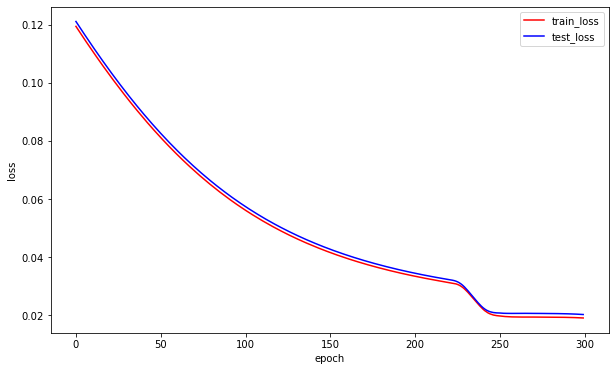

In [20]:
# 画图
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='train_loss', color='r')
plt.plot(test_loss_list, label='test_loss', color='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 评估

In [21]:
summary(model, input_size=(1, 7))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 7]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 6]                    48
│    └─ReLU: 2-2                         [1, 6]                    --
│    └─Linear: 2-3                       [1, 5]                    35
│    └─ReLU: 2-4                         [1, 5]                    --
│    └─Linear: 2-5                       [1, 4]                    24
│    └─ReLU: 2-6                         [1, 4]                    --
│    └─Linear: 2-7                       [1, 2]                    10
├─Sequential: 1-2                        [1, 7]                    --
│    └─Linear: 2-8                       [1, 4]                    12
│    └─ReLU: 2-9                         [1, 4]                    --
│    └─Linear: 2-10                      [1, 5]                    25
│    └─ReLU: 2-

In [23]:
# # 保存模型
# torch.save(model.state_dict(), 'model_autoEncoder.pth')

# # 加载模型
# model.load_state_dict(torch.load('model_autoEncoder.pth'))

# 测试
model.eval()
with torch.no_grad():
    test_output = model(test_data)
    pred_y = test_output.cpu().numpy()

    mse = np.mean((pred_y - test_data.cpu().numpy()) ** 2, axis=1)
    mse_sum = np.sum(mse)
    print('mse_sum = ', mse_sum)


mse_sum =  0.31213912


In [24]:
# 随机从测试集中选取一个样本
idx = np.random.randint(0, len(test_data))
print('idx = ', idx)
right_idx = test_indices[idx]
print('right_idx = ', right_idx)
print('test_data[right_idx] = \n', test_data[idx].cpu().numpy())
# df.iloc[right_idx, 5:12]
print('pred_y[idx] = \n', pred_y[idx])
print('mse[idx] = ', mse[idx])

idx =  6
right_idx =  119
test_data[right_idx] = 
 [0.   0.01 0.09 0.27 0.31 0.25 0.07]
pred_y[idx] = 
 [0.00820199 0.05919217 0.22424547 0.33076927 0.23815523 0.11412582
 0.0253101 ]
mse[idx] =  0.007117506


### 由样本生成二维图像

In [25]:
df.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),normal_value
0,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,0.343806
1,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,0.491583
2,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,0.097901
3,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,0.187709
4,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,0.308737


In [26]:
Distribution

array([[0.  , 0.02, 0.17, ..., 0.29, 0.12, 0.02],
       [0.  , 0.04, 0.21, ..., 0.26, 0.09, 0.01],
       [0.  , 0.02, 0.16, ..., 0.3 , 0.12, 0.02],
       ...,
       [0.01, 0.03, 0.13, ..., 0.3 , 0.22, 0.04],
       [0.01, 0.05, 0.23, ..., 0.24, 0.14, 0.02],
       [0.01, 0.03, 0.23, ..., 0.24, 0.09, 0.01]])

In [27]:
Distribution_tensor = torch.from_numpy(Distribution).float().to(device)

In [28]:
model.eval()
with torch.no_grad():
    encoded = model.encoder(Distribution_tensor)
    encoded = encoded.cpu().numpy()

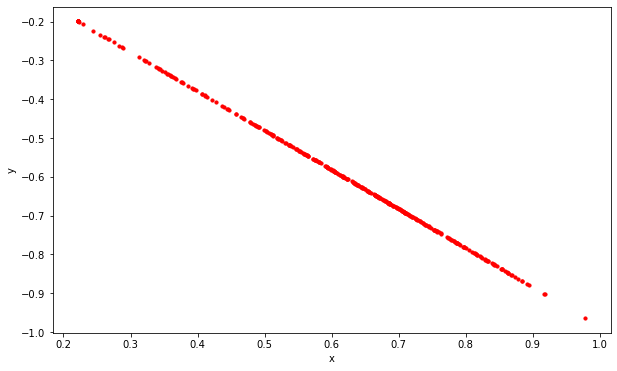

In [34]:
# 用encoded画散点图，看看是否有聚类效果
plt.figure(figsize=(10, 6))
plt.scatter(encoded[:, 0], encoded[:, 1], c='r', s=10)
# plt.scatter(encoded[:, 0], encoded[:, 1], c=df['2 tries'], s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# 保存模型
# torch.save(model.state_dict(), 'model_autoEncoder.pth')

In [31]:
# 加载模型
model.load_state_dict(torch.load('model_autoEncoder.pth'))

<All keys matched successfully>

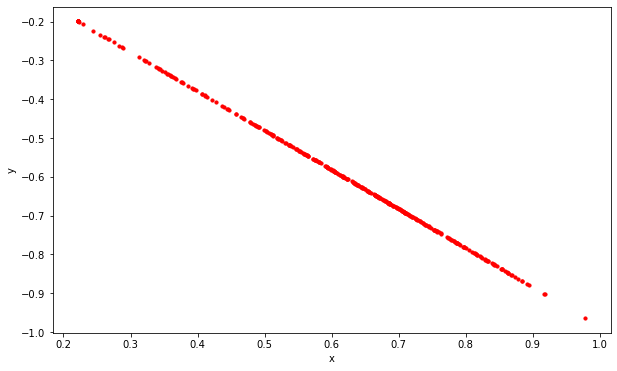

In [32]:
# 用encoded画散点图，看看是否有聚类效果
plt.figure(figsize=(10, 6))
plt.scatter(encoded[:, 0], encoded[:, 1], c='r', s=10)
# plt.scatter(encoded[:, 0], encoded[:, 1], c=df['2 tries'], s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [35]:
df1 = pd.read_excel('word_data_new.xlsx')
df1.head()

,Date,Date.1,Contest number,word,senti,senti_score,cixing,diversity,freq_1,freq_2,vowel_percentage(%),if_weekdays,correlations,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,44926,560,manly,1,0.0000,RB,0.620000,0.264214,0.265298,20.0,0,0.343806,0,2,17,37,29,12,2
1,2022-12-30,44925,559,molar,1,0.0000,JJ,0.777778,0.329989,0.315016,40.0,1,0.491583,0,4,21,38,26,9,1
2,2022-12-29,44924,558,havoc,0,-0.5994,NN,0.001000,0.254738,0.237445,40.0,1,0.097901,0,2,16,38,30,12,2
3,2022-12-28,44923,557,impel,1,0.0000,NN,0.500000,0.287625,0.314575,40.0,1,0.187709,0,3,21,40,25,9,1
4,2022-12-27,44922,556,condo,1,0.0000,NN,0.001000,0.267001,0.290084,40.0,1,0.308737,0,2,17,35,29,14,3


In [36]:
df1['senti'].unique()

array([1, 0, 2], dtype=int64)

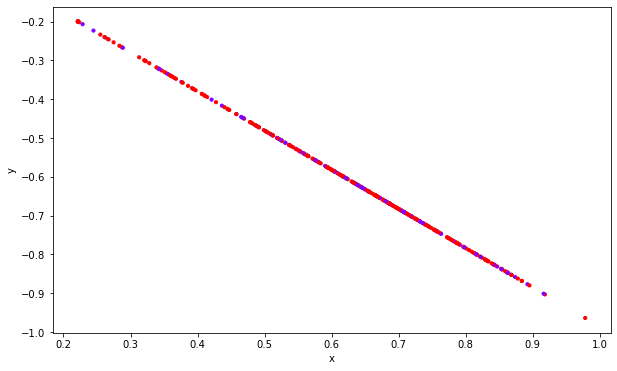

In [62]:
# 用encoded画散点图，看看是否有聚类效果
plt.figure(figsize=(10, 6))
# plt.scatter(encoded[:, 0], encoded[:, 1], c='r', s=10)
plt.scatter(encoded[:, 0], encoded[:, 1], c=df1['if_weekdays'], s=10, cmap='rainbow', label='if_weekdays')
plt.xlabel('x')
plt.ylabel('y')
# plt.legend()
plt.show()

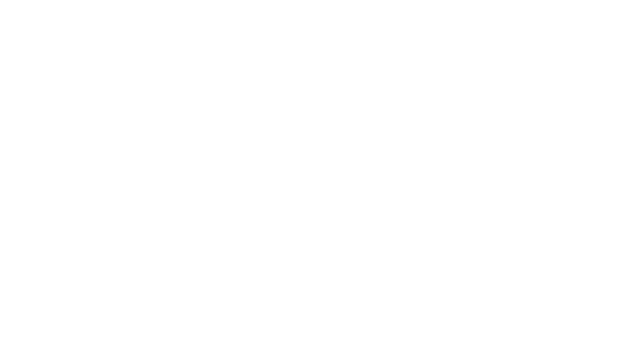

In [47]:
# 用matplotlib画出encoded_histories随着epoch变化的动画
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 0))

def init():
    ax.scatter([], [], c='r', s=10)
    return ax,

def animate(i):
    # ax.clear()
    ax.scatter(encoded_histories[i][:, 0], encoded_histories[i][:, 1], c='r', s=10)
    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(encoded_histories), interval=100, blit=True)
HTML(anim.to_html5_video())

In [63]:
# 创建一个动画，将梯度下降的过程可视化，这里使用的是matplotlib的animation模块
from matplotlib import animation
from IPython.display import HTML

def show_animation(encoded_histories):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
    line, = ax.plot([], [], 'bo', lw=2, label='point')
    x = np.linspace(-2, 5, 100)
    plt.legend()

    def init():
        line.set_data([], [])
        return line, 

    def animate(frame):
        line.set_data(encoded_histories[frame][0, 0], encoded_histories[frame][0, 1])
        plt.title('iteration = {}'.format(frame))
        return line, 

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(encoded_histories), # 这里的frames是指动画的帧数
                                interval=60,  # 这里的interval是指动画的间隔时间 单位是ms
                                blit=True # 这里的blit是指是否只更新动画中改变的部分
                                )
    return HTML(anim.to_html5_video())

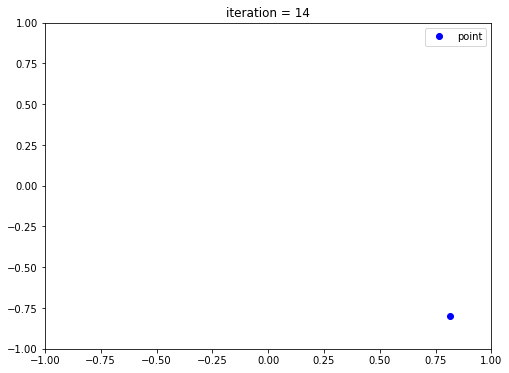

In [64]:
show_animation(encoded_histories)

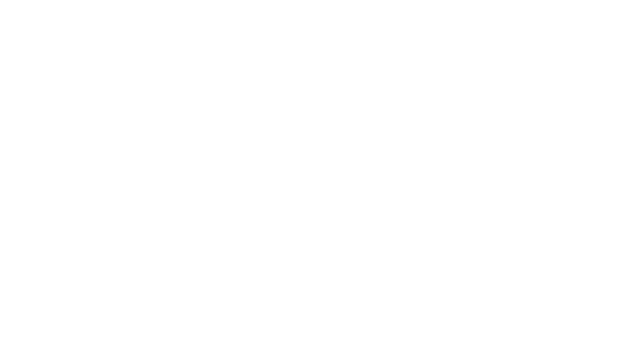

In [59]:
# 使用animation模块画出动态散点图
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

def init():
    ax.scatter(encoded[:, 0], encoded[:, 1], c='r', s=10)
    return ax,

def animate(i):
    # ax.clear()
    ax.scatter(encoded_histories[i][:, 0], encoded_histories[i][:, 1], c='r', s=10)
    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(encoded_histories), interval=100, blit=True)
HTML(anim.to_html5_video())
